<a id='toc'></a>

# Medical Appointment No Shows - Who's To Blame?

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">EDA - Conclusion and limitations</a></li>
<li><a href="#predictions">Appointment predictions</a></li>
<li><a href="#predconc">Predictions conclusion - Who's To Blame?</a></li>
</ul>

<a id='intro'></a>
## Introduction

The dataset includes medical appointment status as well as some patient details of Brazilian families; I'd be interested in investigating the reason why some patients do not show up to their scheduled appointments and whether there are opportunities for improvement in appointment administration that would result in a higher attendance frequency.

The dataset consists of 14 variables as follows:

1. PatientId : Unique identification of a patient
2. AppointmentID : Unique identification of each appointment
3. Gender: Male or Female.
4. ScheduledDay: The day of registering the appointment.
5. AppointmentDay: The day of actual appointment.
6. Age: How old is the patient.
7. Neighbourhood: Where the appointment takes place.
8. Scholarship: Whether the patient is enrolled in [Bolsa_Família](https://en.wikipedia.org/wiki/Bolsa_Fam%C3%ADlia), which is a social welfare program of the Government of Brazil
9. Hipertension: Hypertension, also known as high blood pressure. Part of patient's medical history.
10. Diabetes: Part of patient's medical history.
11. Alcoholism: drinking of alcohol that results in significant mental or physical health problems. Part of patient's medical history.
12. Handcap: handicap, part of patient's medical history.
13. SMS_received: frequent reminders of scheduled appointment.
14. No-show: whether the patient made the actual appointment or not. 'Yes/True' means the patient did not make the appointment.

Several questions will be addressed:

1. Factors driving higher attendance frequency? is it age, gender, medical history or enrollment in Bolsa Família program?

2. Does time has an impact on attendance frequency?

3. Are there certain neighborhoods experiencing higher attendance frequency than others? Why?

4. Is appointment scheduling administered properly?
	
Main dependent variable is appointment status 'No-Show’; rest will be the independent ones.


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
from collections import Counter
from functools import reduce
from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from pyod.models.pca import PCA as PCA_pyod
from time import time

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

In [2]:
# load data
master_df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

In [3]:
# inspect
master_df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [4]:
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [5]:
master_df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [6]:
# Inspect unusual age records that are < 0

master_df[master_df.Age < 0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
99832,4.659432e+14,5775010,F,2016-06-06T08:58:13Z,2016-06-06T00:00:00Z,-1,ROMÃO,0,0,0,0,0,0,No


In [7]:
# Inspect unusual Handcap records that are > 1

master_df[master_df.Handcap > 1].sample(3)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
44686,2.579378e+14,5751751,M,2016-05-31T10:35:08Z,2016-05-31T00:00:00Z,76,INHANGUETÁ,0,1,0,0,3,0,Yes
28840,6.656653e+13,5586010,M,2016-04-15T07:12:28Z,2016-05-03T00:00:00Z,15,ROMÃO,0,0,0,0,3,1,Yes
66043,2.157737e+12,5662393,M,2016-05-05T08:29:02Z,2016-05-05T00:00:00Z,64,TABUAZEIRO,0,1,1,0,2,0,No


In [8]:
# Check for duplicate records

master_df.duplicated().sum()

0

In [9]:
# Check whether each patient has multiple records

master_df.PatientId.nunique(), master_df.AppointmentID.nunique()

(62299, 110527)

In [10]:
# Inspect multiple records of single patient

master_df[master_df.PatientId.duplicated(keep=False)].sort_values(by='PatientId')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
58616,2.263866e+07,5580835,F,2016-04-14T07:23:30Z,2016-05-03T00:00:00Z,22,INHANGUETÁ,0,0,0,0,0,1,No
88585,2.263866e+07,5715081,F,2016-05-18T13:37:12Z,2016-06-08T00:00:00Z,23,INHANGUETÁ,0,0,0,0,0,1,No
83628,5.216894e+07,5704816,F,2016-05-16T16:42:19Z,2016-05-16T00:00:00Z,28,JARDIM DA PENHA,0,0,0,0,0,0,No
49826,5.216894e+07,5607220,F,2016-04-20T11:22:15Z,2016-05-17T00:00:00Z,28,JARDIM DA PENHA,0,0,0,0,0,0,No
11009,6.485121e+07,5683383,F,2016-05-11T07:28:23Z,2016-05-13T00:00:00Z,29,MARUÍPE,0,0,0,0,0,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32033,9.999320e+14,5736368,M,2016-05-25T08:14:58Z,2016-05-25T00:00:00Z,90,JABOUR,0,0,0,0,0,0,No
32023,9.999320e+14,5710157,M,2016-05-17T15:22:01Z,2016-05-17T00:00:00Z,90,JABOUR,0,0,0,0,0,0,No
62194,9.999320e+14,5616762,M,2016-04-25T14:46:41Z,2016-05-04T00:00:00Z,90,JABOUR,0,0,0,0,0,1,No
104616,9.999320e+14,5772701,M,2016-06-03T16:04:03Z,2016-06-07T00:00:00Z,90,JABOUR,0,0,0,0,0,1,No


### Data Cleaning

- Convert ID columns to string, no arithmetic operations will be performed on them
- Convert Scheduled and Appointment columns to date time, then calculate elapsed time from scheduling day till appointment day
- Convert No-show to 0 and 1 for convenience
- Make all header lower case and rename columns for better representation
- Drop records with age < 0, assuming that 0 represent new born
- Adjust Handcap values that are > 1 to be 1, assuming that these are just typos
- Unify age variable of patients with multiple records

In [11]:
# Make copy of master df

master_df_clean = master_df.copy()

In [12]:
# Convert ID columns to string, no arithmetic operations will be performed on them

master_df_clean.PatientId, master_df_clean.AppointmentID = master_df_clean.PatientId.astype(str), \
master_df_clean.AppointmentID.astype(str)

In [13]:
# calculate elapsed time from scheduling day till actual appointment day

master_df_clean.ScheduledDay = master_df_clean.ScheduledDay.apply(np.datetime64)
master_df_clean['scheduledDay_x'] = master_df_clean['ScheduledDay'].dt.date

master_df_clean.AppointmentDay = master_df_clean.AppointmentDay.apply(np.datetime64)
master_df_clean.scheduledDay_x = master_df_clean.scheduledDay_x.apply(np.datetime64)

master_df_clean['elapsed_days'] = pd.to_timedelta((master_df_clean['AppointmentDay'] - master_df_clean['scheduledDay_x'])).dt.days
master_df_clean['elapsed_days'] = master_df_clean['elapsed_days'].apply(np.int64)

# drop new scheduled day column as I need full timestamp data which is already included in the original column
master_df_clean.drop(columns = ['scheduledDay_x'], inplace =True)

# Inspect
master_df_clean.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,elapsed_days
0,29872499824296.0,5642903,F,2016-04-29 18:38:08,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0
1,558997776694438.0,5642503,M,2016-04-29 16:08:27,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0
2,4262962299951.0,5642549,F,2016-04-29 16:19:04,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,0
3,867951213174.0,5642828,F,2016-04-29 17:29:31,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0
4,8841186448183.0,5642494,F,2016-04-29 16:07:23,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0


In [14]:
# check for outliers
master_df_clean.elapsed_days.value_counts().sort_index()

-6          1
-1          4
 0      38563
 1       5213
 2       6725
        ...  
 155       10
 162       11
 169        8
 176       16
 179       10
Name: elapsed_days, Length: 131, dtype: int64

In [15]:
# records having -ve values
master_df_clean[master_df_clean.elapsed_days < 0]

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,elapsed_days
27033,7839272661752.0,5679978,M,2016-05-10 10:51:53,2016-05-09,38,RESISTÊNCIA,0,0,0,0,1,0,Yes,-1
55226,7896293967868.0,5715660,F,2016-05-18 14:50:41,2016-05-17,19,SANTO ANTÔNIO,0,0,0,0,1,0,Yes,-1
64175,24252258389979.0,5664962,F,2016-05-05 13:43:58,2016-05-04,22,CONSOLAÇÃO,0,0,0,0,0,0,Yes,-1
71533,998231581612122.0,5686628,F,2016-05-11 13:49:20,2016-05-05,81,SANTO ANTÔNIO,0,0,0,0,0,0,Yes,-6
72362,3787481966821.0,5655637,M,2016-05-04 06:50:57,2016-05-03,7,TABUAZEIRO,0,0,0,0,0,0,Yes,-1


In [16]:
master_df_clean.shape

(110527, 15)

In [17]:
# drop -ve values as they are probably erroneous

master_df_clean = master_df_clean[~master_df_clean.elapsed_days < 0].copy()

master_df_clean.reset_index(drop= True, inplace = True)

In [18]:
master_df_clean.shape

(110522, 15)

In [19]:
# convert No-show to 0 and 1 for convenience

master_df_clean['No-show'].replace(to_replace=['No', 'Yes'], value=[0, 1], inplace=True)

In [20]:
# Make all header lower case and rename columns for better representation

master_df_clean.columns = master_df_clean.columns.str.lower()

master_df_clean.rename(columns={'patientid':'patient_id', 'appointmentid':'appointment_id', 
                                'scheduledday': 'scheduling_day', 'appointmentday': 'appointment_day', 
                                'scholarship':'enrolled_in_Bolsa_Família', 'hipertension': 'hypertension', 
                                'handcap':'handicap', 'no-show':'no_show'}, inplace=True)

In [21]:
# Drop records with age < 0

master_df_clean = master_df_clean[master_df_clean.age >= 0]

master_df_clean.reset_index(drop= True, inplace = True)

In [22]:
# Adjust Handicap values that are > 1 to be 1 as it is not clear whether these entries are errors or representation
# of various stages of Handicap

master_df_clean.loc[master_df_clean.handicap > 1 , 'handicap'] = 1

In [23]:
# Unify age variable of patients with multiple records, I'll use the first recorded age as lead.  
# this will be done through creating a temp sorted dataframe for duplicate patient ids,
# identify gaps in recorded ages for single patient record,
# filter on each unique id then create a dict with IDs being keys and first recorded age as values
# finally map dict keys to main dataframe patient IDs

duplicate_id = master_df_clean[master_df_clean.patient_id.duplicated(keep=False)].sort_values(by='patient_id')

duplicate_id['first'] = duplicate_id['age']

duplicate_id['last'] = duplicate_id['age'].shift(-1)

duplicate_id['gap'] = duplicate_id['age'].shift(-1) - duplicate_id['age']

duplicate_id_fltrd = duplicate_id[(duplicate_id.first != duplicate_id.last) & (duplicate_id.gap == 1)]

duplicate_id_dict = duplicate_id_fltrd.set_index('patient_id').to_dict()['age']

master_df_clean.loc[master_df_clean.patient_id.isin(duplicate_id_fltrd.patient_id), 'age'] = \
master_df_clean.patient_id.map(duplicate_id_dict)

# inspect

master_df_clean[master_df_clean.patient_id.isin(duplicate_id_fltrd.patient_id)].sort_values(by='patient_id', ascending=False)

,patient_id,appointment_id,gender,scheduling_day,appointment_day,age,neighbourhood,enrolled_in_Bolsa_Família,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,elapsed_days
51734,999479168794227.0,5732030,M,2016-05-24 10:53:01,2016-05-30,45.0,RESISTÊNCIA,0,0,0,0,0,1,1,6
80671,999479168794227.0,5615162,M,2016-04-25 11:46:13,2016-05-09,45.0,RESISTÊNCIA,0,0,0,0,0,0,0,14
51730,999479168794227.0,5615134,M,2016-04-25 11:42:54,2016-05-02,45.0,RESISTÊNCIA,0,0,0,0,0,1,1,7
77207,99821629648.0,5659968,F,2016-05-04 15:11:26,2016-05-13,19.0,BELA VISTA,0,0,0,0,0,0,0,9
77206,99821629648.0,5659933,F,2016-05-04 15:06:51,2016-05-06,19.0,BELA VISTA,0,0,0,0,0,0,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94181,1124242331227.0,5700106,F,2016-05-16 09:08:01,2016-06-06,5.0,VILA RUBIM,0,0,0,0,0,1,0,21
57053,1124242331227.0,5644761,F,2016-05-02 09:04:48,2016-05-16,5.0,VILA RUBIM,0,0,0,0,0,0,1,14
19091,11238367556569.0,5675795,F,2016-05-09 14:21:41,2016-05-13,28.0,ROMÃO,0,1,0,0,0,0,0,4
10283,11238367556569.0,5723118,F,2016-05-20 07:58:35,2016-05-20,28.0,ROMÃO,0,1,0,0,0,0,0,0


<a id='eda'></a>
## Exploratory Data Analysis


### Factors driving higher attendance frequency? is it age, gender, medical history or enrollment in Bolsa Família program?

In [24]:
# Grouping multiple records of unique patients into single records and computing average, min, max of some appointment details
# this is to avoid double counting of same patient records while analysing independent variables 
# and also to provide better representation of appointment details to facilitate comparability

# First, group records and make calculations
unique_no_show_df = master_df_clean.groupby('patient_id')[['no_show']].agg(['count', 'mean'])

unique_no_show_df.columns = unique_no_show_df.columns.droplevel()

unique_elapsed_days_df = master_df_clean.groupby('patient_id')[['elapsed_days']].agg(['mean', 'max', 'min'])

unique_elapsed_days_df.columns = unique_elapsed_days_df.columns.droplevel()

unique_sms_received_df = master_df_clean.groupby('patient_id')[['sms_received']].agg(['mean'])

unique_sms_received_df.columns = unique_sms_received_df.columns.droplevel()

dfs = [unique_no_show_df, unique_elapsed_days_df, unique_sms_received_df]

grouped_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), dfs) \
.rename(columns = {'count':'appointment_count', 'mean_x': 'no_show_mean', 'mean_y': 'elapsed_days_mean', 
                   'max':'elapsed_days_max', 'min':'elapsed_days_min', 'mean':'sms_received_mean'})

master_df_clean.index = master_df_clean.patient_id

# Then merge to obtain other variables, 
# keep first occuence only as these variables are supposed to be fixed for a single patient

grouped_df = pd.merge(grouped_df, master_df_clean.drop_duplicates(subset=['patient_id'], keep='first'), 
                      left_index=True, right_index=True, how='left')

master_df_clean.reset_index(drop=True, inplace=True)

grouped_df.reset_index(drop=True, inplace=True)

columns_list = grouped_df.columns.tolist()

columns_sort = columns_list[6:18]+columns_list[0:6]

grouped_df = grouped_df[columns_sort]

In [25]:
# duplicate intervals to bypass 'include_lowest' bug as suggested --> (https://github.com/pandas-dev/pandas/issues/23164)
# age groups categorization follows this link,
# https://brasilemsintese.ibge.gov.br/populacao/distribuicao-da-populacao-por-grandes-grupos-de-idade.html
# I split the age group of 15-64 into two groups for better representation

bins = pd.IntervalIndex.from_tuples([(-0.001,0), (0, 14), (14.999,15), (15, 24), (24.999,25), (25, 64), (64.999,65), 
                                     (65,122)])
labels = ['Children','Children','Youth', 'Youth', 'Adults','Adults','Seniors','Seniors']

grouped_df['age_group'] = pd.cut(grouped_df.age, bins, include_lowest =True).map(dict(zip(bins, labels)))

In [26]:
# calculate attendance frequency per each age group as a percentage of total group

age_groups = grouped_df.age_group.value_counts()

low_atnd_freq = grouped_df[grouped_df.no_show_mean > 0].age_group.value_counts()

hgh_atnd_freq = grouped_df[grouped_df.no_show_mean == 0].age_group.value_counts()

out_low = low_atnd_freq / age_groups

out_low.sort_values(ascending=False)

Youth       0.343972
Adults      0.285897
Children    0.283677
Seniors     0.216782
Name: age_group, dtype: float64

In [27]:
out_hgh = hgh_atnd_freq / age_groups

out_hgh.sort_values(ascending=False)

Seniors     0.783218
Children    0.716323
Adults      0.714103
Youth       0.656028
Name: age_group, dtype: float64

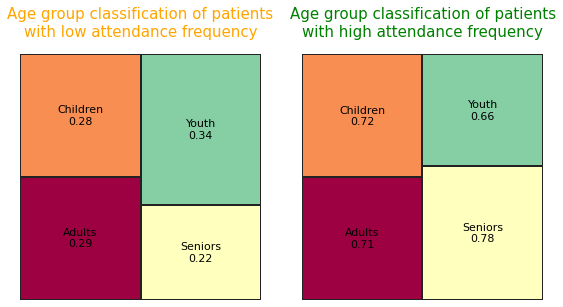

In [28]:
# Plot the results

fig, axes = plt.subplots(ncols=2, figsize=(8, 4))
fig.tight_layout()
ax1, ax2 = axes

# setup plot labels, box sizes and colors

labels_low = [i + '\n' + str((round(v,2))) for i, v in out_low.items()]
sizes_low = out_low.values
colors_low = [plt.cm.Spectral(i/float(len(labels_low))) for i in range(len(labels_low))]

labels_hgh = [i + '\n' + str((round(v,2))) for i, v in out_hgh.items()]
sizes_hgh = out_hgh.values
colors_hgh = [plt.cm.Spectral(i/float(len(labels_hgh))) for i in range(len(labels_hgh))]

# Draw Plot
squarify.plot(sizes=sizes_low, label=labels_low, color=colors_low, alpha=1, bar_kwargs=dict(linewidth=2, edgecolor="#222222"), text_kwargs=dict(fontsize=11), ax=ax1);

squarify.plot(sizes=sizes_hgh, label=labels_hgh, color=colors_hgh, alpha=1, bar_kwargs=dict(linewidth=2, edgecolor="#222222"), text_kwargs=dict(fontsize=11), ax=ax2);

# Decorate
ax1.set_title('Age group classification of patients' + '\n' + 'with low attendance frequency', fontsize=15, y=1.05, c='orange')
ax2.set_title('Age group classification of patients' + '\n' + 'with high attendance frequency', fontsize=15, y=1.05, c='green')
ax1.axis('off'); ax2.axis('off');

In [29]:
# Create summary table for patient's gender and medical condition 
# to apply value count on the whole dataframe instead of one variable at a time
# Same concept of splitting population as before

summary_high_show_df = grouped_df[grouped_df.no_show_mean == 0].copy()

summary_low_show_df =  grouped_df[grouped_df.no_show_mean > 0].copy()

summary_high_show_df.drop(columns={'patient_id','appointment_id','scheduling_day','appointment_day',
                                   'age','neighbourhood', 'appointment_count', 'no_show_mean',
                                   'elapsed_days_mean', 'elapsed_days_max', 'elapsed_days_min', 
                                   'elapsed_days_min', 'age_group', 'sms_received_mean'}, inplace = True)

summary_low_show_df.drop(columns={'patient_id','appointment_id','scheduling_day','appointment_day',
                                  'age','neighbourhood', 'appointment_count', 'no_show_mean',
                                  'elapsed_days_mean', 'elapsed_days_max', 'elapsed_days_min', 
                                  'elapsed_days_min', 'age_group', 'sms_received_mean'}, inplace = True)

summary_high_show_df = summary_high_show_df.apply(pd.Series.value_counts)

summary_low_show_df = summary_low_show_df.apply(pd.Series.value_counts)

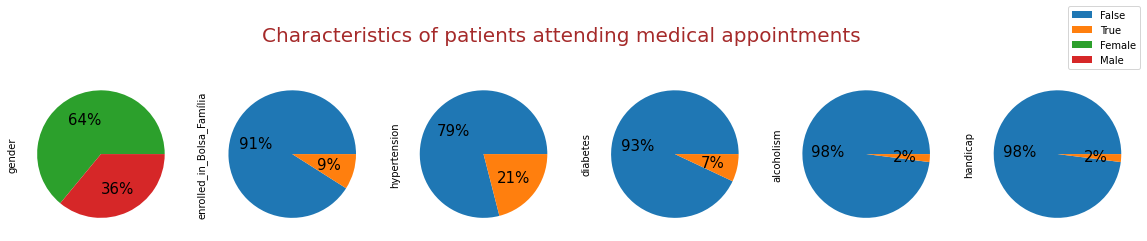

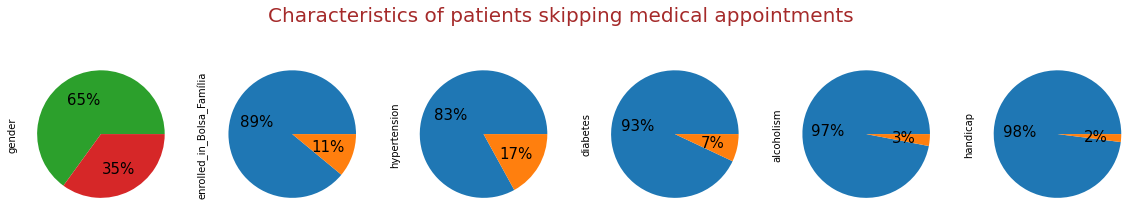

In [30]:
# Calculate relative weight of each condition and plotting

summary_high_show_df.transform(lambda x: round(x / x.sum(),2)).plot(kind='pie', 
                                                                    subplots = True, legend = False, figsize = (20, 10), 
                                                                    fontsize = 15, 
                                                                    autopct = \
                                                                    lambda p: '{:.0f}%'.format(round(p)) if p > 0 else '', 
                                                                    labels = None);

plt.gcf().suptitle('Characteristics of patients attending medical appointments', fontsize=20, y=.68, color = 'brown')

plt.legend(["False", "True", 'Female', 'Male'], bbox_to_anchor=(1.05, 1), loc = 4)

summary_low_show_df.transform(lambda x: round(x / x.sum(),2)).plot(kind='pie', 
                                                                   subplots = True, legend = False, figsize = (20, 10),
                                                                   fontsize = 15, 
                                                                   autopct = \
                                                                   lambda p: '{:.0f}%'.format(round(p)) if p > 0 else '', 
                                                                   labels = None);

plt.gcf().suptitle("Characteristics of patients skipping medical appointments", fontsize=20, y=.68, color = 'brown');

Seniors takes the lead being highest attendance frequency age group, while youth leads the low attendance one. It makes sense as health deteriorates with age.

The dataset is dominated by female presence; it seems that women are receiving extra medical care than men.

Patients' characteristics do not significantly vary between those who attend or skip their medical appointment. However, enrolment in Bolsa Familia program, hypertension and diabetes medical conditions are the highest among patients who attend.

### Does time has an impact on attendance frequency?

In [31]:
# Resample and inspect

grouped_df[grouped_df.no_show_mean > 0].groupby(['scheduling_day'])['no_show_mean'].count().resample('1m').sum()

scheduling_day
2015-11-30       1
2015-12-31      18
2016-01-31      14
2016-02-29      60
2016-03-31    1059
2016-04-30    6770
2016-05-31    9137
2016-06-30     602
Freq: M, Name: no_show_mean, dtype: int64

In [32]:
grouped_df[grouped_df.no_show_mean > 0].groupby(['appointment_day'])['no_show_mean'].count().resample('1m').sum()

appointment_day
2016-04-30     1134
2016-05-31    14617
2016-06-30     1910
Freq: M, Name: no_show_mean, dtype: int64

In [33]:
grouped_df[grouped_df.no_show_mean == 0].groupby(['scheduling_day'])['no_show_mean'].count().resample('1m').sum()

scheduling_day
2015-12-31       35
2016-01-31       31
2016-02-29      123
2016-03-31     1600
2016-04-30    10657
2016-05-31    27127
2016-06-30     5064
Freq: M, Name: no_show_mean, dtype: int64

In [34]:
grouped_df[grouped_df.no_show_mean == 0].groupby(['appointment_day'])['no_show_mean'].count().resample('1m').sum()

appointment_day
2016-04-30     1845
2016-05-31    34074
2016-06-30     8718
Freq: M, Name: no_show_mean, dtype: int64

In [35]:
# Summary of appointments by weekday

master_df_clean['day'] = master_df_clean.appointment_day.dt.day_name()

master_df_clean.groupby('day')['no_show'].count()

day
Friday       19019
Monday       22713
Saturday        39
Thursday     17246
Tuesday      25638
Wednesday    25866
Name: no_show, dtype: int64

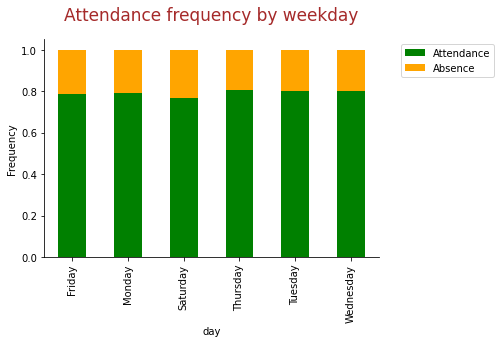

In [36]:
# attendance frequency by weekdays

master_df_clean.groupby('day')['no_show'].value_counts(normalize=True).unstack().plot(
    kind = 'bar', stacked = True, ylabel = 'Frequency', color = ['green', 'orange']);

# Decoration9

plt.title('Attendance frequency by weekday', fontsize = 17, c = 'brown', y = 1.06)

plt.legend(["Attendance", "Absence"], bbox_to_anchor = (1.05, 1), loc = 'upper left')

plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0)

In [37]:
# Check whether decreas in elapsed time between shceduling and actual appointment date impact attendace ferquency
# 16 being average elapsed timed of the dataset

round(grouped_df[(grouped_df.elapsed_days_mean >= 16) & (grouped_df.no_show_mean == 0)].age_group.value_counts(normalize=True),2)

Adults      0.53
Children    0.21
Seniors     0.16
Youth       0.10
Name: age_group, dtype: float64

In [38]:
round(grouped_df[(grouped_df.elapsed_days_mean < 16) & (grouped_df.no_show_mean == 0)].age_group.value_counts(normalize=True),2)

Adults      0.51
Children    0.23
Seniors     0.14
Youth       0.12
Name: age_group, dtype: float64

May appears to be squeezed compared to other months as most appointments were scheduled to take place during this month. It might be because this period follows the heavy festive months where people are busy celebrating according to [this](https://www.lonelyplanet.com/brazil/narratives/planning/month-by-month), but still this can be considered as an improvement opportunity for appointment administration to spread appointments across months.

There is no preference for specific weekday over the other when it comes to attendance frequency, despite that Thursday/Wednesday experienced improved attendance frequency and Friday/Saturday are the lowest, it’s not significantly different than rest of weekdays. 

No appointments where scheduled to take place on Sunday which is understandable being a weekend day but given that attendance frequency on Saturday, which is also a weekend day, is comparable to the rest of the weekdays it implies that patients are willing to attend appointments on weekends. This can be also considered as an improvement opportunity for appointment administration to spread appointments across weekdays regardless of weekends. 

On the other hand, decrease in elapsed time between scheduling and actual appointment date does not result in a significant decrease in missed appointments. Which is a bit surprising actually and warrants further investigation of underlying appointment scheduling data.

### Are there certain neighborhoods experiencing higher attendance frequency than others? Why?

In [39]:
# Check appointment distribution among Neighborhoods

round(master_df_clean.neighbourhood.value_counts(normalize=True) * 100, 2)

JARDIM CAMBURI                 6.98
MARIA ORTIZ                    5.25
RESISTÊNCIA                    4.01
JARDIM DA PENHA                3.51
ITARARÉ                        3.18
                               ... 
ILHA DO BOI                    0.03
ILHA DO FRADE                  0.01
AEROPORTO                      0.01
ILHAS OCEÂNICAS DE TRINDADE    0.00
PARQUE INDUSTRIAL              0.00
Name: neighbourhood, Length: 81, dtype: float64

In [40]:
# Create a summary table for attendance frequency per each neighborhood
# to facilitate comparison among each and identify which neighborhood experienced most successful appointments

appointments_by_neighbourhoods = grouped_df.groupby(['neighbourhood'])['appointment_count'].sum()

attendance_by_neighbourhood = grouped_df[grouped_df.no_show_mean == 0]. \
groupby(['neighbourhood'])['appointment_count'].sum()

frequency_of_attendance= attendance_by_neighbourhood / appointments_by_neighbourhoods

frequency_of_attendance = frequency_of_attendance.to_frame().rename(columns={'appointment_count':'frequency_of_attendance'})

appointments_by_neighbourhoods = appointments_by_neighbourhoods.to_frame(). \
rename(columns={'appointment_count':'total_appointments'})

neighbourhoods_summary = pd.merge(frequency_of_attendance, appointments_by_neighbourhoods, 
                                  left_index=True, right_index=True, how='left')

temp_df = master_df_clean.groupby('neighbourhood')[['elapsed_days', 'sms_received']].agg(['mean'])

temp_df.columns = temp_df.columns.droplevel(level=1)

neighbourhoods_summary = pd.merge(neighbourhoods_summary, temp_df, left_index=True, right_index=True, how='left'). \
rename(columns={'elapsed_days':'elapsed_days_mean', 'sms_received':'reminder_frequency'})

neighbourhoods_summary.reset_index(inplace=True)

neighbourhoods_summary.rename(columns={'index':'neighbourhood'}, inplace=True)

neighbourhoods_summary.elapsed_days_mean = neighbourhoods_summary.elapsed_days_mean.astype(int)

neighbourhoods_summary = round(neighbourhoods_summary,2)

In [41]:
# Stats of top 10 neighborhoods with highest attendance frequency

neighbourhoods_summary.sort_values(by='frequency_of_attendance', ascending =False).head(10).describe()

,frequency_of_attendance,total_appointments,elapsed_days_mean,reminder_frequency
count,10.000000,10.000000,10.000000,10.000000
mean,0.762000,991.200000,8.300000,0.273000
std,0.103473,1408.686133,4.137901,0.135323
min,0.680000,1.000000,0.000000,0.000000
25%,0.702500,43.500000,7.000000,0.212500
50%,0.710000,282.500000,8.500000,0.305000
75%,0.785000,1244.000000,11.500000,0.370000
max,1.000000,3877.000000,14.000000,0.430000


In [42]:
# Stats of top 10 neighborhoods with lowest attendance frequency

neighbourhoods_summary.sort_values(by='frequency_of_attendance').head(10).describe()

,frequency_of_attendance,total_appointments,elapsed_days_mean,reminder_frequency
count,10.000000,10.000000,10.00000,10.000000
mean,0.524000,1311.600000,9.80000,0.360000
std,0.021187,1004.985815,4.54117,0.094985
min,0.490000,10.000000,5.00000,0.250000
25%,0.510000,462.500000,7.25000,0.322500
50%,0.525000,1067.000000,8.50000,0.345000
75%,0.540000,2250.000000,11.00000,0.372500
max,0.550000,2853.000000,21.00000,0.600000


In [43]:
# details of top 10 neighborhoods with highest attendance frequency

neighbourhoods_summary.sort_values(by='frequency_of_attendance', ascending =False).head(10)

,neighbourhood,frequency_of_attendance,total_appointments,elapsed_days_mean,reminder_frequency
51,PARQUE INDUSTRIAL,1.00,1,0,0.00
0,AEROPORTO,0.88,8,14,0.12
31,ILHA DO BOI,0.80,35,4,0.20
73,SOLON BORGES,0.74,469,12,0.38
54,PONTAL DE CAMBURI,0.71,69,9,0.35
47,MORADA DE CAMBURI,0.71,96,7,0.43
80,VILA RUBIM,0.71,851,12,0.37
39,JARDIM DA PENHA,0.70,3877,10,0.37
13,CONSOLAÇÃO,0.69,1375,7,0.25
66,SANTA MARTHA,0.68,3131,8,0.26


In [44]:
# details of top 10 neighborhoods with lowest attendance frequency

neighbourhoods_summary.sort_values(by='frequency_of_attendance').head(10)

,neighbourhood,frequency_of_attendance,total_appointments,elapsed_days_mean,reminder_frequency
70,SANTOS DUMONT,0.49,1276,12,0.35
32,ILHA DO FRADE,0.50,10,6,0.60
40,JESUS DE NAZARETH,0.51,2853,11,0.28
61,SANTA CECÍLIA,0.51,448,21,0.40
33,ILHA DO PRÍNCIPE,0.52,2266,5,0.33
1,ANDORINHAS,0.53,2262,8,0.25
60,ROMÃO,0.54,2214,8,0.35
62,SANTA CLARA,0.54,506,11,0.32
4,BARRO VERMELHO,0.55,423,7,0.34
6,BENTO FERREIRA,0.55,858,9,0.38


In [45]:
# will compare age and gender composition among top 2 neighborhood of each highest and lowest groups as 
# other variables are approximatly similar and will be further investigated in appointment adminstration analysis section 

print('ILHA DO BOI gender and age composition :', '\n','\n',
      round(grouped_df[grouped_df.neighbourhood == 'ILHA DO BOI'].gender.value_counts(normalize=True),2),'\n','\n',
      round(grouped_df[grouped_df.neighbourhood == 'ILHA DO BOI'].age_group.value_counts(normalize=True),2),'\n','\n',
      '-'* 20,'\n','\n',
      'AEROPORTO gender and age composition :', '\n','\n',
      round(grouped_df[grouped_df.neighbourhood == 'AEROPORTO'].gender.value_counts(normalize=True),2),'\n','\n',
      round(grouped_df[grouped_df.neighbourhood == 'AEROPORTO'].age_group.value_counts(normalize=True),2)
     )

ILHA DO BOI gender and age composition : 
 
 F    0.55
M    0.45
Name: gender, dtype: float64 
 
 Adults     0.64
Seniors    0.23
Youth      0.14
Name: age_group, dtype: float64 
 
 -------------------- 
 
 AEROPORTO gender and age composition : 
 
 F    0.57
M    0.43
Name: gender, dtype: float64 
 
 Adults    1.0
Name: age_group, dtype: float64


In [46]:
print('ILHA DO FRADE gender and age composition :', '\n','\n',
      round(grouped_df[grouped_df.neighbourhood == 'ILHA DO FRADE'].gender.value_counts(normalize=True),2),'\n','\n',
      round(grouped_df[grouped_df.neighbourhood == 'ILHA DO FRADE'].age_group.value_counts(normalize=True),2),'\n','\n',
      '-'* 20,'\n','\n',
      'JESUS DE NAZARETH gender and age composition :', '\n','\n',
      round(grouped_df[grouped_df.neighbourhood == 'SANTOS DUMONT'].gender.value_counts(normalize=True),2),'\n','\n',
      round(grouped_df[grouped_df.neighbourhood == 'SANTOS DUMONT'].age_group.value_counts(normalize=True),2)
     )

ILHA DO FRADE gender and age composition : 
 
 M    1.0
Name: gender, dtype: float64 
 
 Adults     0.8
Seniors    0.2
Name: age_group, dtype: float64 
 
 -------------------- 
 
 JESUS DE NAZARETH gender and age composition : 
 
 F    0.62
M    0.38
Name: gender, dtype: float64 
 
 Adults      0.52
Children    0.20
Youth       0.14
Seniors     0.13
Name: age_group, dtype: float64


In [47]:
# Check if a neighborhood didn’t have any successful appointment

neighbourhoods_summary[neighbourhoods_summary.frequency_of_attendance.isnull()]

,neighbourhood,frequency_of_attendance,total_appointments,elapsed_days_mean,reminder_frequency
34,ILHAS OCEÂNICAS DE TRINDADE,NaN,2,29,0.0


In [48]:
# Check details of this neighborhood

master_df_clean[master_df_clean.neighbourhood == 'ILHAS OCEÂNICAS DE TRINDADE']

,patient_id,appointment_id,gender,scheduling_day,appointment_day,age,neighbourhood,enrolled_in_Bolsa_Família,hypertension,diabetes,alcoholism,handicap,sms_received,no_show,elapsed_days,day
48753,534986855114.0,5583947,F,2016-04-14 12:25:43,2016-05-13,51.0,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,0,0,1,29,Friday
48764,7256429752481.0,5583948,F,2016-04-14 12:26:13,2016-05-13,58.0,ILHAS OCEÂNICAS DE TRINDADE,0,0,0,0,0,0,1,29,Friday


Comparing summary statistics of top 10 neighborhoods having highest and lowest attendance frequency indicates that neither shorter elapsed time nor higher frequent reminders have a significant impact on attendance frequency.

By examining the demographic composition of top neighborhoods in from each attendance category (highest/lowest) we can conclude that neighborhoods with demographic composition of less senior patients had less attendance frequency. This confirms my earlier observation that older patients have high attendance frequency.

However, ILHAS OCEÂNICAS DE TRINDADE neighborhood did not experience any successful appointments contrary to my expectation given the composition of gender and age group. Maybe because elapsed time was 28 days and no frequent reminders were sent to patients.

This will be further investigated in appointment administration section.

It warrants additional data to conclude why exactly some Neighborhoods experience higher attendance frequency than others (nature of visits i.e. is it for severe illness 'cancer for example' or just customary, distance between patient and appoint location, commute times, venue, etc...)

### Is appointment scheduling administered properly?

In [49]:
# inspect patients with multiple appointments as it will give better overview on scheduling practices

grouped_df[grouped_df.appointment_count > 1].sort_values(by='appointment_count', ascending=False).head(10)

,patient_id,appointment_id,gender,scheduling_day,appointment_day,age,neighbourhood,enrolled_in_Bolsa_Família,hypertension,diabetes,alcoholism,handicap,appointment_count,no_show_mean,elapsed_days_mean,elapsed_days_max,elapsed_days_min,sms_received_mean,age_group
49246,822145925426128.0,5638995,M,2016-04-29 08:38:44,2016-04-29,38.0,REDENÇÃO,0,0,0,0,0,88,0.011364,0.772727,20,0,0.034091,Adults
61951,99637671331.0,5642880,M,2016-04-29 18:03:27,2016-04-29,46.0,JABOUR,0,0,0,0,0,84,0.047619,0.476190,19,0,0.000000,Adults
11422,26886125921145.0,5638965,M,2016-04-29 08:37:28,2016-04-29,63.0,SANTA MARTHA,0,0,0,1,0,70,0.000000,0.485714,28,0,0.028571,Adults
15726,33534783483176.0,5639084,M,2016-04-29 08:42:23,2016-04-29,44.0,DA PENHA,0,0,0,1,0,65,0.000000,0.000000,0,0,0.000000,Adults
45115,75797461494159.0,5710749,M,2016-05-17 17:47:20,2016-05-17,49.0,JARDIM CAMBURI,0,0,0,0,0,62,0.032258,1.838710,28,0,0.080645,Adults
53067,871374938638855.0,5639078,M,2016-04-29 08:42:11,2016-04-29,63.0,ROMÃO,0,0,0,1,0,62,0.048387,1.370968,14,0,0.000000,Adults
10591,258424392677.0,5640300,M,2016-04-29 10:28:14,2016-04-29,49.0,BONFIM,0,1,0,1,0,62,0.000000,0.516129,32,0,0.000000,Adults
36005,6264198675331.0,5642798,M,2016-04-29 17:15:53,2016-04-29,59.0,JESUS DE NAZARETH,1,0,0,0,0,62,0.048387,1.016129,21,0,0.032258,Adults
39125,66844879846766.0,5639109,F,2016-04-29 08:43:27,2016-04-29,52.0,BENTO FERREIRA,0,0,0,0,0,57,0.017544,0.245614,7,0,0.017544,Adults
53141,872278549442.0,5638970,M,2016-04-29 08:37:41,2016-04-29,40.0,REPÚBLICA,0,0,0,0,0,55,0.018182,0.509091,10,0,0.036364,Adults


In [50]:
# inspect records of patients with several appointments

master_df_clean[(master_df_clean.patient_id == '1484143378533.0')].sort_values(by='scheduling_day') \
.drop(columns={'enrolled_in_Bolsa_Família', 'hypertension', 'diabetes', 'alcoholism', 'handicap'})

,patient_id,appointment_id,gender,scheduling_day,appointment_day,age,neighbourhood,sms_received,no_show,elapsed_days,day
2304,1484143378533.0,5573128,F,2016-04-12 11:56:51,2016-04-29,56.0,GRANDE VITÓRIA,1,0,17,Friday
21811,1484143378533.0,5624634,F,2016-04-26 16:36:37,2016-05-02,56.0,GRANDE VITÓRIA,1,1,6,Monday
21871,1484143378533.0,5624644,F,2016-04-26 16:38:19,2016-05-03,56.0,GRANDE VITÓRIA,0,0,7,Tuesday
21930,1484143378533.0,5624663,F,2016-04-26 16:40:50,2016-05-04,56.0,GRANDE VITÓRIA,1,0,8,Wednesday
21865,1484143378533.0,5624674,F,2016-04-26 16:41:54,2016-05-05,56.0,GRANDE VITÓRIA,1,0,9,Thursday
21896,1484143378533.0,5624726,F,2016-04-26 16:48:57,2016-05-06,56.0,GRANDE VITÓRIA,1,1,10,Friday
13840,1484143378533.0,5640785,F,2016-04-29 11:24:43,2016-05-03,56.0,GRANDE VITÓRIA,1,0,4,Tuesday
21812,1484143378533.0,5649276,F,2016-05-02 18:56:40,2016-05-09,56.0,GRANDE VITÓRIA,0,0,7,Monday
21872,1484143378533.0,5649283,F,2016-05-02 18:57:31,2016-05-10,56.0,GRANDE VITÓRIA,0,0,8,Tuesday
21931,1484143378533.0,5649297,F,2016-05-02 18:59:07,2016-05-11,56.0,GRANDE VITÓRIA,1,0,9,Wednesday


In [51]:
master_df_clean[(master_df_clean.patient_id == '17798942295934.0')].sort_values(by='appointment_day') \
.drop(columns={'enrolled_in_Bolsa_Família', 'hypertension', 'diabetes', 'alcoholism', 'handicap'})

,patient_id,appointment_id,gender,scheduling_day,appointment_day,age,neighbourhood,sms_received,no_show,elapsed_days,day
2312,17798942295934.0,5625177,F,2016-04-27 07:00:57,2016-04-29,39.0,ILHA DO PRÍNCIPE,0,0,2,Friday
47910,17798942295934.0,5631287,F,2016-04-28 06:42:04,2016-05-02,39.0,ILHA DO PRÍNCIPE,1,0,4,Monday
47949,17798942295934.0,5642997,F,2016-05-02 06:56:06,2016-05-04,39.0,ILHA DO PRÍNCIPE,0,0,2,Wednesday
21829,17798942295934.0,5655974,F,2016-05-04 07:27:04,2016-05-06,39.0,ILHA DO PRÍNCIPE,0,0,2,Friday
47911,17798942295934.0,5660849,F,2016-05-05 06:53:21,2016-05-09,39.0,ILHA DO PRÍNCIPE,0,0,4,Monday
47950,17798942295934.0,5671676,F,2016-05-09 07:00:47,2016-05-11,39.0,ILHA DO PRÍNCIPE,0,0,2,Wednesday
56759,17798942295934.0,5658248,F,2016-05-04 10:46:13,2016-05-12,39.0,ILHA DO PRÍNCIPE,1,0,8,Thursday
21830,17798942295934.0,5682828,F,2016-05-11 06:37:06,2016-05-13,39.0,ILHA DO PRÍNCIPE,0,0,2,Friday
47912,17798942295934.0,5688086,F,2016-05-12 06:37:10,2016-05-16,39.0,ILHA DO PRÍNCIPE,0,0,4,Monday
47951,17798942295934.0,5697937,F,2016-05-16 07:04:55,2016-05-18,39.0,ILHA DO PRÍNCIPE,0,0,2,Wednesday


In [52]:
# Calculate attendace frequency of patients having multiple appointments in the same day

temp_df = master_df_clean[master_df_clean.patient_id.duplicated(keep=False)].sort_values(by='patient_id')

temp_df['gap'] = temp_df['appointment_day'].shift(-1) - temp_df['appointment_day']

temp_df['gap'] = temp_df['gap'].dt.days

temp_df_fltrd = temp_df[(temp_df.no_show == 1) & (temp_df.gap == 0)]

round(temp_df_fltrd.shape[0] / temp_df[temp_df.no_show == 1].shape[0],2)

0.08

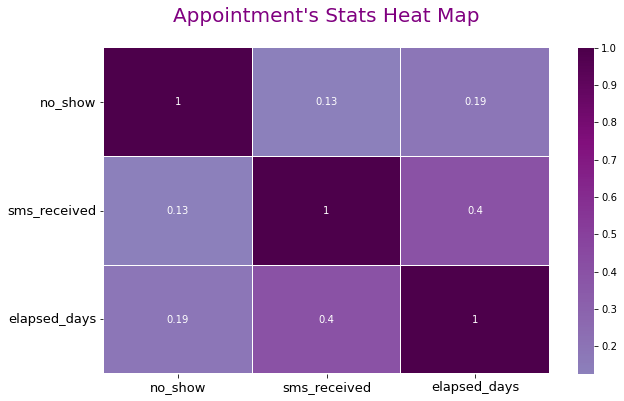

In [53]:
# Heatmap for appointment stats

appointment_stats = master_df_clean.groupby(['appointment_id'])[['no_show', 'sms_received', 'elapsed_days']].mean()

# Plot

plt.figure(figsize=(10,6))

sns.heatmap(appointment_stats.corr(), xticklabels = appointment_stats.corr().columns, 
            yticklabels = appointment_stats.corr().columns, cmap = 'BuPu', center = 0, annot = True, linewidths = .01)

# Decorations

plt.title('Appointment\'s Stats Heat Map', fontsize = 20, color = 'purple' , y = 1.06)

plt.xticks(fontsize = 13)

plt.yticks(rotation = 0, fontsize = 13, va = "center");

I'll comment on appointment administration activities then will discuss my concerns on the dataset itself

##### Analysis of appointment administration activities

8% of missed appointments were scheduled in the same day, this is noted for patients having multiple appointments. Another development opportunity for appointment administration is to steer away from scheduling multiple appointments in the same day; unless there is a need to.

Friday is a common day for missed appointments as noted from the detailed records inspected above and those of ILHAS OCEÂNICAS DE TRINDADE neighborhood. This is also confirmed by earlier analysis of attendance by weekday as Friday was one of the lowest.

Frequent reminders are associated with the length of elapsed days as noted from +ve correlation between sms received and elapsed time. However, correlation coefficient indicate weak linear relationship which can be observed in the appointment records of the patients above. Take patient # 1484143378533 as an example, we can observe that reminders are not sent systematically for similar elapsed time period same as for patient # 17798942295934 but with less frequency. Switch sorting of each table to reproduce these observation. 

This can be an area for improvement in appointment administration by following a systematic approach in sending reminders to patients and/or increasing the frequency or methods of reminders. However, given the weak correlation that is almost nonlinear between the frequency of reminders and attendance; associated costs of increasing or changing reminder methods need to be closely examined. 

Weak +ve correlation that is almost nonlinear between elapsed time and attendance frequency need to be investigated further, as a strong +ve linear relationship is expected unless there are limited sources of medical services providers.


##### concerns on data integrity

Actually, appointment administration and related data needs a lot further investigation than any other independent variable in this dataset to confirm data integrity, as several red flags were noted as follows:

1. Insignificant impact of shorter appointment lead times on attendance frequency
2. Time stamps and appointment ID discrepancies, discussed further below.

Upon inspecting the appointment record of the 2 patients above, having around 80% attendance frequency and a total of 50 appointments, I noticed that:

1. Several appointments were scheduled in the same day within a very short time, sometimes less than a minute!

2. Appointment ID sequence gap is significant compared to the short scheduling time.

To elaborate more, let’s take the record of patient # 1484143378533 as an example. We can see that there are 5 appointments scheduled on the 2nd of May’16 with the following time stamps sorted in an ascending order ‘18:56:40’, ‘18:57:31, ‘18:59:07’, ‘19:00:08’,’ 19:01:32’. Each appoint has a unique ID as follows ‘5649276’, ‘5649283’,’ 5649297’,’ 5649306,’ 5649316’. Such data sparks a lot of concerns:

- How is it possible to have such quick calls/registrations?

- How come gaps in appointment ID are significant within such short time span? Are all Neighborhoods linked to the same registration system?

- What’s the point of having such pattern of registration, does they all relate to each other? Should some of them be cancelled?

- Is No show record for these particular appointments correct?

- IF it’s not a registration problem/error rather a data gathering one, does this affect the accuracy of other independent variables?

Unfortunately, answers to these questions can’t be extracted from the current dataset. But I’m Curious!

<a id='conclusions'></a>

## Conclusion

1. Senior age group have higher attendance frequency than others
	
2. Youth age group most likely will skip their medical appointments
	
3. Enrolment in Bolsa Familia program, hypertension and diabetes medical conditions are common characteristics of patients with higher attendance frequency
	
4. Seniors and adults age group shows a slight improvement in attendance frequency with shorter lead times.

5. No preference for specific weekday over the other when it comes to attendance frequency.


## Appointment administration improvement opportunities 

1. Spread appointments across months and weekdays regardless of weekends.

2. Avoid scheduling multiple appointments in the same day for a single patient. Unless there is a need to.

3. Follow a systematic approach when sending reminders to patients and consider increasing the frequency and/or methods of reminders while closely monitoring the associated costs of doing so.
	

## Limitations
	
- How was the appointment scheduled is not clear.
	
- Sufficient details about appointments are not provided (Type, employee ID, physician, venue, etc…).
	
- Medical history of children has some unusual entries like alcoholism. I did not disregard this.
	
- Count and timing of sms reminders are not provided
	
- I assumed age of 0 relates to newborns and not data entry error

- Appointment administration and related data anomalies can lead to different interpretations if proved to be valid, actually it casts doubts on the integrity of the whole dataset.

<a id='predictions'></a>

## Appointment predictions

#### modeling workflow:

- Data preprocessing including:
  - Removing data points having identical features but different class labels, since I can't conclude on the reason for such instances from the given data set.
  - Outlier detection and removal using PyOD.
- Checking for multicollinearity.
- Feature selection using different techniques.
- Testing several models with different feature sets.
- Hyperparameter tuning for best performing model(s).
- Testing multiple sampling techniques to address class imbalances.
- Concluding on best performing model and features.

check out this [GOLD MINE](https://machinelearningmastery.com/), the blog has been a great help guiding this modeling.

In [54]:
master_df_clean_ml = master_df_clean.copy()

master_df_clean_ml.age = master_df_clean_ml.age.astype('int64')

master_df_clean_ml.no_show = master_df_clean_ml.no_show.replace({0:1, 1:0})

master_df_clean_ml.rename(columns = {'no_show': 'attend'}, inplace = True)

gender = pd.get_dummies(master_df_clean_ml.gender, drop_first=True)

master_df_clean_ml = pd.concat([master_df_clean_ml, gender], axis = 1)

master_df_clean_ml.drop(columns=['appointment_id', 'gender', 'neighbourhood', 
                                 'scheduling_day', 'day'], axis =1 , inplace = True)

master_df_clean_ml.head()

,patient_id,appointment_day,age,enrolled_in_Bolsa_Família,hypertension,diabetes,alcoholism,handicap,sms_received,attend,elapsed_days,M
0,29872499824296.0,2016-04-29,62,0,1,0,0,0,0,1,0,0
1,558997776694438.0,2016-04-29,56,0,0,0,0,0,0,1,0,1
2,4262962299951.0,2016-04-29,62,0,0,0,0,0,0,1,0,0
3,867951213174.0,2016-04-29,8,0,0,0,0,0,0,1,0,0
4,8841186448183.0,2016-04-29,56,0,1,1,0,0,0,1,0,0


In [55]:
master_df_clean_ml.drop(columns = ['patient_id', 'appointment_day'], inplace = True)

columns_list = master_df_clean_ml.columns.tolist()

columns_sort = columns_list[0:7]+columns_list[8:]+columns_list[7:8]

master_df_clean_ml = master_df_clean_ml[columns_sort]

master_df_clean_ml.columns

Index(['age', 'enrolled_in_Bolsa_Família', 'hypertension', 'diabetes',
       'alcoholism', 'handicap', 'sms_received', 'elapsed_days', 'M',
       'attend'],
      dtype='object')

In [56]:
master_df_clean_ml.shape

(110521, 10)

In [57]:
# removing identical features having different classes, since I cannot conclude why such instance happen from the available
# data. Such instances will degrade model performance

# Mask for identical feats with different class labels

dup = master_df_clean_ml[(master_df_clean_ml.duplicated(subset = master_df_clean_ml.columns[0:9], keep = False))].\
sort_values(by = ['age', 'enrolled_in_Bolsa_Família', 'hypertension', 'diabetes',
       'alcoholism', 'handicap', 'sms_received', 'elapsed_days', 'M'], ascending =True)

# Creating a matrix to capture rows to be deleted, all duplicated rows with different class labels will 
# have a unique pattern, it's better to inspect the data outside of Jupyter Notebook to better identify the pattern.

dup['unique'] = dup['attend'].shift(-1) - dup['attend']

dup['next'] = dup['elapsed_days'].shift(-1) - dup['elapsed_days']

dup['previous'] = dup['elapsed_days'].shift() - dup['elapsed_days']

dup['prev_unique'] = dup['attend'].shift() - dup['attend']

dup.to_csv('dup.csv')

dup.tail(10)

,age,enrolled_in_Bolsa_Família,hypertension,diabetes,alcoholism,handicap,sms_received,elapsed_days,M,attend,unique,next,previous,prev_unique
74421,97,0,0,0,0,0,0,4,0,1,0.0,-4.0,0.0,0.0
24127,97,0,1,0,0,0,0,0,0,1,-1.0,0.0,4.0,0.0
74219,97,0,1,0,0,0,0,0,0,0,1.0,0.0,0.0,1.0
86776,97,0,1,0,0,0,0,0,0,1,0.0,21.0,0.0,-1.0
46626,98,0,1,0,0,0,0,21,0,1,0.0,0.0,-21.0,0.0
69924,98,0,1,0,0,0,0,21,0,1,0.0,-20.0,0.0,0.0
79265,100,0,0,0,0,1,0,1,1,1,0.0,0.0,20.0,0.0
79267,100,0,0,0,0,1,0,1,1,1,-1.0,2.0,0.0,0.0
63910,115,0,0,0,0,1,0,3,0,0,0.0,0.0,-2.0,1.0
63913,115,0,0,0,0,1,0,3,0,0,NaN,NaN,0.0,0.0


Indexes 24127 and 74219 are an example of duplicated exact features having different class labels. Here we have 3 instances, index 86776 as well, of which 2 are having different class labels; I'll be removing instances similar to these 2 from the data as I can't conclude on the exact reason for such difference and it will degrade model performance.

In [58]:
# Capturing all rows to be deleted

dup = dup[(((dup.attend == 0) & (dup.unique == 1) & (dup.next == 0) & (dup.previous == 0) & (dup.prev_unique == 1)) |
           ((dup.attend == 1) & (dup.unique == -1) & (dup.next == 0)) |
           ((dup.attend == 0) & (dup.previous == 0) & (dup.prev_unique == 1)) | 
           ((dup.attend == 1) & (dup.unique == -1) & (dup.previous == 0)) |
           ((dup.attend == 0) & (dup.unique == 1) & (dup.next == 0)) |
           ((dup.attend == 0) & (dup.unique == 0) & (dup.next == 0) & (dup.previous == 0) & (dup.prev_unique == 1)) |
           ((dup.attend == 0) & (dup.unique == 0) & (dup.next == 0) & (dup.previous == 0) & (dup.prev_unique == 0)) |
           ((dup.attend == 0) & (dup.unique == 1) & (dup.next == 0) & (dup.previous == 0) & (dup.prev_unique == 0)))]

# Removing captured rows

master_df_clean_ml = master_df_clean_ml[~master_df_clean_ml.index.isin(dup.index)]

# Separate features and labels

features = master_df_clean_ml.drop(columns = ['attend'])
labels = master_df_clean_ml['attend']

# Rescaling

features_resc = StandardScaler().fit_transform(features)

In [59]:
dup.shape, master_df_clean_ml.shape, features.shape

((28481, 14), (82040, 10), (82040, 9))

In [60]:
# Outlier detection and removal, setting n_component to 1 as I want the analysis to be based on the PC explaining the 
# highest variance in the dataset

pca_pyod = PCA_pyod(n_components = 1).fit(features_resc)

features_pyod = features.copy()

# identifying instances labeled as outliers for further analysis

features_pyod['outlier_score'] = pca_pyod.decision_scores_

features_pyod['outlier_labels'] = pca_pyod.labels_

# analysing inliers
pyod_inliers = features_pyod[features_pyod.outlier_labels == 0]

pyod_inliers.describe()

,age,enrolled_in_Bolsa_Família,hypertension,diabetes,alcoholism,handicap,sms_received,elapsed_days,M,outlier_score,outlier_labels
count,73836.000000,73836.000000,73836.000000,73836.000000,73836.0,73836.0,73836.000000,73836.000000,73836.00000,73836.000000,73836.0
mean,38.126375,0.084281,0.206674,0.073067,0.0,0.0,0.274568,8.401606,0.33955,12.880160,0.0
std,23.446116,0.277811,0.404922,0.260249,0.0,0.0,0.446299,12.992729,0.47356,2.855094,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,8.520519,0.0
25%,18.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,10.743259,0.0
50%,38.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.000000,0.00000,12.192680,0.0
75%,57.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,13.000000,1.00000,14.867744,0.0
max,115.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,71.000000,1.00000,19.890970,0.0


In [61]:
features.shape, pyod_inliers.shape

((82040, 9), (73836, 11))

In [62]:
features.alcoholism.value_counts()[1], features.handicap.value_counts()[1]

(3062, 2031)

A total of 8,201 instances were identified as outliers, of which 5,093 related to alcoholism and handicap which were removed completely. I'll agree with such cleanup since these two features did not have material effect on attendance frequency as noted in my earlier EDA.

I'll explore further what constitute the rest of the outliers identified apart from alcoholism and handicap features.

In [63]:
# analysing outliers

pyod_outliers = features_pyod[features_pyod.outlier_labels == 1]

pyod_outliers.sort_values(by = 'outlier_score').tail()

,age,enrolled_in_Bolsa_Família,hypertension,diabetes,alcoholism,handicap,sms_received,elapsed_days,M,outlier_score,outlier_labels
102785,77,0,1,1,0,0,1,179,0,52.824574,1
102790,80,0,1,1,0,0,1,179,0,52.887447,1
102789,27,1,0,0,0,0,1,179,0,53.080886,1
27564,83,0,1,0,0,1,1,155,1,53.664454,1
102786,73,0,1,1,0,1,0,179,1,60.410892,1


In [64]:
# inspect records related to the ones having highest outlier scores

pyod_outliers[(pyod_outliers.age == 73)].sort_values(by = 'elapsed_days', ascending=False)

,age,enrolled_in_Bolsa_Família,hypertension,diabetes,alcoholism,handicap,sms_received,elapsed_days,M,outlier_score,outlier_labels
102786,73,0,1,1,0,1,0,179,1,60.410892,1
102784,73,0,1,1,0,0,0,179,1,52.754363,1
102798,73,0,1,0,0,0,1,176,0,50.244029,1
46767,73,0,1,0,0,1,0,112,0,43.087837,1
46777,73,0,0,0,0,0,0,108,1,30.835148,1
71429,73,0,0,0,0,0,0,97,0,27.131999,1
69883,73,0,0,0,0,0,0,90,1,25.938845,1
69927,73,0,1,1,0,0,0,87,1,28.463956,1
92897,73,0,0,0,0,0,0,79,0,22.205979,1
92871,73,0,0,0,0,0,1,79,0,23.039475,1


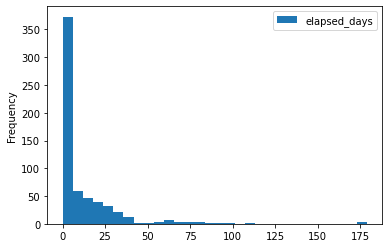

In [65]:
features[features.age == 73].plot(kind='hist', y = 'elapsed_days', bins = 30);

Cleanup is done basically on instances having abnormal elapsed days along with being handicapped/alcoholism.

In [66]:
features_pyod = features_pyod[features_pyod.outlier_labels == 0]

labels_pyod = labels[labels.index.isin(features_pyod.index)]

features_pyod.drop(columns=['outlier_score', 'outlier_labels'], inplace = True)

features_pyod.describe()

,age,enrolled_in_Bolsa_Família,hypertension,diabetes,alcoholism,handicap,sms_received,elapsed_days,M
count,73836.000000,73836.000000,73836.000000,73836.000000,73836.0,73836.0,73836.000000,73836.000000,73836.00000
mean,38.126375,0.084281,0.206674,0.073067,0.0,0.0,0.274568,8.401606,0.33955
std,23.446116,0.277811,0.404922,0.260249,0.0,0.0,0.446299,12.992729,0.47356
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000
25%,18.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000
50%,38.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.000000,0.00000
75%,57.000000,0.000000,0.000000,0.000000,0.0,0.0,1.000000,13.000000,1.00000
max,115.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,71.000000,1.00000


In [67]:
# Dropping unnecessary columns after outlier removal

features_pyod.drop(columns=['alcoholism', 'handicap'], inplace = True)

# Rescaling

features_resc_pyod = StandardScaler().fit_transform(features_pyod)

In [68]:
features_pyod.shape, features_resc_pyod.shape, labels_pyod.shape

((73836, 7), (73836, 7), (73836,))

In [69]:
# Checking for severe multicollinearity 

# In regression, "multicollinearity" refers to predictors that are correlated with other predictors (variable/feature).  
# Multicollinearity occurs when the model includes multiple factors that are correlated not just to the response variable,
# but also to each other.

# A VIF of 1 (the minimum possible VIF) means the tested predictor is not correlated with the other predictors. 
# The rule of thumb is that VIF shouldn’t be higher than 10.

vif_data = pd.DataFrame()
vif_data['features'] = features.columns
vif_data['vif'] = [variance_inflation_factor(features.values, i) for i in range(len(features.columns))]

vif_data

,features,vif
0,age,2.522819
1,enrolled_in_Bolsa_Família,1.065972
2,hypertension,1.902788
3,diabetes,1.340123
4,alcoholism,1.071317
5,handicap,1.037380
6,sms_received,1.647823
7,elapsed_days,1.638009
8,M,1.332881


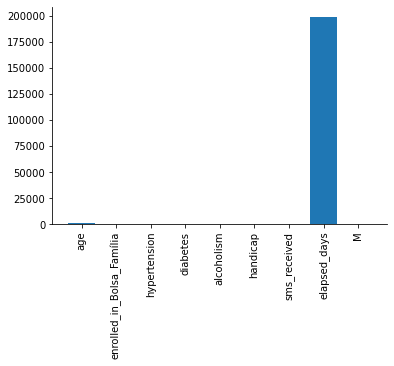

In [70]:
# Feature selection chi2

# chi-square test measures dependence between stochastic variables (whose values depend on outcomes of a random phenomenon), 
# so using this function “weeds out” the features that are, the most likely to be independent of class and therefore 
# irrelevant for classification.

features_best = SelectKBest(chi2, k = 3)
features_best.fit_transform(features, labels)
cols = features_best.get_support(indices=True)
features_best_df_chi2 = features.iloc[:,cols]


# # printing scores, it’s better to visualize though
# for i in range(len(features_best.scores_)):
#     print('%s: %f' % (features.columns[i], features_best.scores_[i]))
    
# plot the scores
plt.bar([features.columns[i] for i in range(len(features_best.scores_))], features_best.scores_, );
plt.xticks(rotation = 90)
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

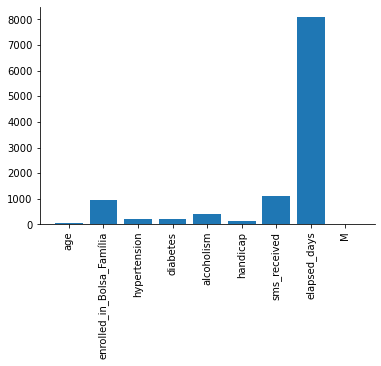

In [71]:
# Feature selection f_classif

features_best = SelectKBest(k = 3)
features_best.fit_transform(features, labels)
cols = features_best.get_support(indices=True)
features_best_df_fcla = features.iloc[:,cols]

# # for i in range(len(features_best.scores_)):
# #     print('%s: %f' % (features.columns[i], features_best.scores_[i]))
    
# plot the scores
plt.bar([features.columns[i] for i in range(len(features_best.scores_))], features_best.scores_);
plt.xticks(rotation = 90)
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

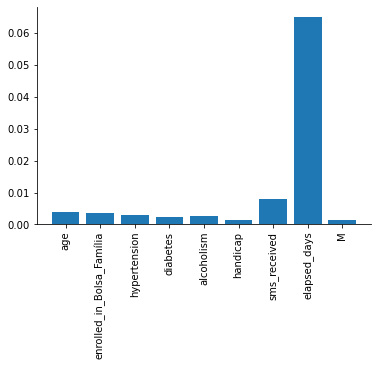

In [72]:
# Feature selection Mutual

features_best = SelectKBest(mutual_info_classif, k = 3)
features_best.fit_transform(features, labels)
cols = features_best.get_support(indices=True)
features_best_df_mutual = features.iloc[:,cols]

# for i in range(len(features_best.scores_)):
#     print('%s: %f' % (features.columns[i], features_best.scores_[i]))

# plot the scores
plt.bar([features.columns[i] for i in range(len(features_best.scores_))], features_best.scores_);
plt.xticks(rotation = 90)
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

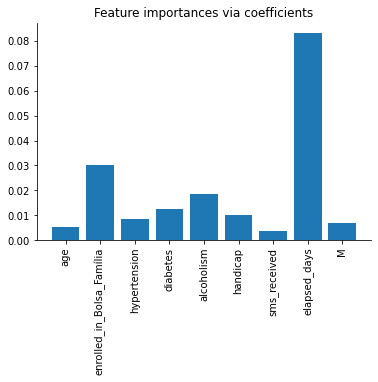

In [73]:
# Feature selection Lasso

lasso = LassoCV().fit(features_resc, labels)
importance = np.abs(lasso.coef_)
feature_names = np.array(features.columns)

plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.xticks(rotation = 90)
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

As noted earlier in the EDA section, current features are not informative of output class.

In [74]:
# Select only top 3 features from lasso

threshold = np.sort(importance)[-3]

tic = time()

sfm = SelectFromModel(lasso, threshold=threshold).fit(features_resc, labels)

toc = time()

print(f"Done in {toc - tic:.3f}s", '\n' ,"Features selected by SelectFromModel: "
      f"{feature_names[sfm.get_support()]}")

features_best_df_sfm = features[feature_names[sfm.get_support()]]

Done in 2.769s 
 Features selected by SelectFromModel: ['enrolled_in_Bolsa_Família' 'alcoholism' 'elapsed_days']


In [75]:
# Building a dataframe for all unique best selected features across all methods

cols = [features_best_df_chi2.columns, features_best_df_fcla, features_best_df_mutual.columns, features_best_df_sfm]

feats = {x for l in cols for x in l}

features_top = features[feats]

features_top

,elapsed_days,age,alcoholism,sms_received,enrolled_in_Bolsa_Família
0,0,62,0,0,0
1,0,56,0,0,0
2,0,62,0,0,0
3,0,8,0,0,0
4,0,56,0,0,0
...,...,...,...,...,...
110514,35,42,0,1,0
110515,35,53,0,1,0
110516,35,56,0,1,0
110517,35,51,0,1,0


In [76]:
# Dataframe of top common feature(s) across all methods

features_ulti = features_top[['elapsed_days']]

In [77]:
features.shape, features_pyod.shape

((82040, 9), (73836, 7))

In [78]:
labels.value_counts(normalize=True)

1    0.923208
0    0.076792
Name: attend, dtype: float64

I'll evaluate models using repeated stratified k-fold cross-validation, using different feature sets.

The k-fold cross-validation procedure provides a good general estimate of model performance that is not too optimistically biased, compared to a single train-test split. k=10 means each fold will contain about x/10 examples. Where x represents n_samples. So using the features set, each fold will have 8,204 examples.

Stratified means that each fold will contain the same mixture of examples by class, that is about 92% to 8% attendance and no-show cases respectively if we are using the features set.

Repeated means that the evaluation process will be performed multiple times to help avoid fluke results and better capture the variance of the chosen model. I'll use 3 repeats. This means a single model will be fit and evaluated 10 * 3 or 30 times and the mean and standard deviation of these runs will be reported.

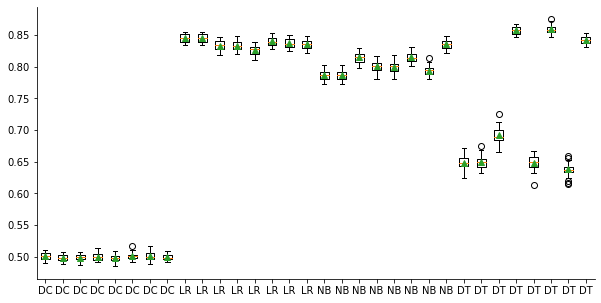

In [79]:
# All models

models = [('DC', DummyClassifier(strategy= 'stratified')), ('LR', LogisticRegression(class_weight='balanced')), 
          ('NB', GaussianNB()), ('DT', tree.DecisionTreeClassifier(class_weight='balanced'))]

feats = [('features', features), ('features_rescaled', features_resc), ('Chi2', features_best_df_chi2), 
         ('f_classif', features_best_df_fcla), ('mutual_calssif', features_best_df_mutual), 
         ('lasso', features_best_df_sfm), ('top_features', features_top), ('ultimate_features', features_ulti)]

results = []

names = []

metric = 'roc_auc'

for name, model in models:
    for feat_name, feat in feats:
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(model, feat, labels, scoring=metric, cv=cv, n_jobs=-1)
        names.append(name)
        results.append(scores)
#         print('%s : \n %s ---> Mean ROC_AUC ---> %.2f (Std: %f)' % (name, feat_name, scores.mean(), scores.std()))

plt.figure(figsize=(10,5))
plt.boxplot(results, labels=names, showmeans=True);
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

DT - Decision Tree is highest performing model using the 6th feature set which is selected using Lasso.

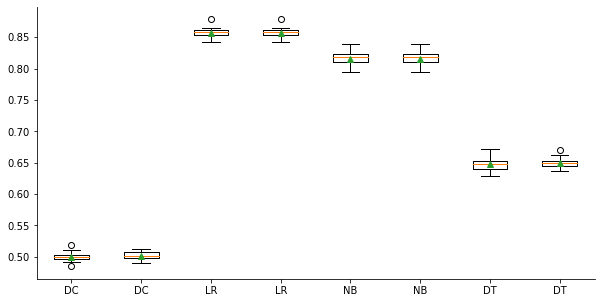

In [80]:
feats = [('features_pyod', features_pyod), ('features_rescaled_pyod', features_resc_pyod)]

results = []

names = []

for name, model in models:
    for feat_name, feat in feats:
        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        scores = cross_val_score(model, feat, labels_pyod, scoring=metric, cv=cv, n_jobs=-1)
        names.append(name)
        results.append(scores)
#         print('%s : \n %s ---> Mean ROC_AUC ---> %.2f (Std: %f)' % (name, feat_name, scores.mean(), scores.std()))

plt.figure(figsize=(10,5))
plt.boxplot(results, labels=names, showmeans=True);
plt.gca().spines["top"].set_alpha(0.0); plt.gca().spines["right"].set_alpha(0.0);

LR - Logistic Regression is highest performing model using features trimmed by PyOD. I'll be comparing between these two models.

### Precision: 
Is the ratio of correctly predicted positive observations (TP) to the total predicted positive observations (TP/TP+FP). Taking attendance calss as an example, precision address the following question: of all patients that the classifier labeled as attended, how many actually attended? in other terms we can say that our model predicts X% of the time, a patient will attend.

### Recall (Sensitivity): 
Is the ratio of correctly predicted positive observations to all observations related to the class in question. Taking attendance class as an example, Recall address the following question: of all the patients that truly attended, how many did the classifier labeled? (TP/TP+FN)

### F1 score: 
Is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. F1 is usually more useful than accuracy, especially in an uneven class distribution. Accuracy works best if false positives and false negatives have similar values. If the value of false positives and false negatives are very different, it’s better to look at both Precision and Recall. (2*(Recall * Precision) / (Recall + Precision))

### Confusion Matrix:

Confusion matrix does a pretty good job clearing any 'confusion' that the above terms might have caused to you. The below table shows how the results of predictions vs actuals are displayed in scikit-learn's confusion matrix, we can shuffle how results are displayed using the 'label' parameter. Note that not all confusion matrixes do display results in same setup, so know your matrix before judging a classifier.

Columns represent predictions, rows are actuals.

                   Predictions
    ---------------------------------------
    |        No         |        Yes      |
    |------------------ |-----------------|
    | 'True Negative'   | 'False Positive'|
    | 'False Negative'  | 'True Positive' |
    

Let's take first confusion matrix we have below (logistic regression cross validation) as an example and link the matrix to the metric discussed above and shown in the classification report. For 'not_attend' class label:

- Precision: (TP/TP+FP) = (3618 / 3618 + 14434) = .20
- Recall: (TP/TP+FN) = (3618 / 3618 + 1132) or (3618 / 4750*) = .76
- F1-score: (2*(Recall * Precision) / (Recall + Precision)) = (2*(.20 * .76) / (.20 + .76)) = .316 (.32 rounded)

(*) can be found in 'support' column. The column 'support' displays how many object of class x were in the test set, it is not a representation of the total number of samples for this specific class unless cross validation is used.

Given the current setup, 'not_attend' class is displayed as true negative/false negative in the matrix, how does this fits into the precision/recall formula? Positive and negative in this case are generic names for the predicted classes, you can invert what you are "trying to predict" and thereby get two scores as displayed in the classification report; actually the classification report auto calculate these metrics regardless of your prediction goals.

### ROC_AUC:

I'll use ROC_AUC as a general performance measure across different models, however, final decision on which model performs best is not dependent on the ROC_AUC threshold.

I'd consider a classifier to be working properly if it minimize False Positives (patients predicted to show-up but actually did not) even at the expense of high False Negatives (patients predicted to NOT show-up but actually did show-up), below is a clarification for such decision:

- Normally, all patients are expected to show-up to their medical appointments.
- Appointment setting teams need to focus efforts and resources on those who have a higher tendency of actually not showing up.

So if a classifier did predict a show-up, which is normally expected, but it turns out to be a no show; then we've excluded this case (patient) from team's scope for setting up a thorough appointment reminder process. This is not desirable.

Thus, I'll be giving priority for recall on the minority classes (no-shows) while minimizing false positives.

More on ROC_AUC [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

<a id='logcross'></a>

In [81]:
clf = LogisticRegression(class_weight='balanced')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(clf, features_pyod, labels_pyod, scoring=metric, cv=cv, n_jobs=-1)
predictions = cross_val_predict(clf, features_pyod, labels_pyod, cv = 10, n_jobs = -1)

print(classification_report(labels_pyod, predictions, target_names=['not_attend', 'attend']), '-'*40, '\n',
      confusion_matrix(labels_pyod, predictions), '\n', '-'*40, '\n',
      'Mean ROC_AUC: %f (Std: %f)' % (scores.mean(), scores.std()))

              precision    recall  f1-score   support

  not_attend       0.20      0.76      0.32      4750
      attend       0.98      0.79      0.88     69086

    accuracy                           0.79     73836
   macro avg       0.59      0.78      0.60     73836
weighted avg       0.93      0.79      0.84     73836
 ---------------------------------------- 
 [[ 3618  1132]
 [14434 54652]] 
 ---------------------------------------- 
 Mean ROC_AUC: 0.857254 (Std: 0.005395)


<li><a href="#treecross">DT cross_val</a></li>

<a id='logroc'></a>

In [82]:
labels_pyod.value_counts(normalize=True)

1    0.935668
0    0.064332
Name: attend, dtype: float64

training time: 2.079 s
prediction time: 0.016 s
              precision    recall  f1-score   support

  not_attend       0.20      0.77      0.32       943
      attend       0.98      0.79      0.88     13825

    accuracy                           0.79     14768
   macro avg       0.59      0.78      0.60     14768
weighted avg       0.93      0.79      0.84     14768
 ---------------------------------------- 
 [[  724   219]
 [ 2900 10925]] 
 ----------------------------------------


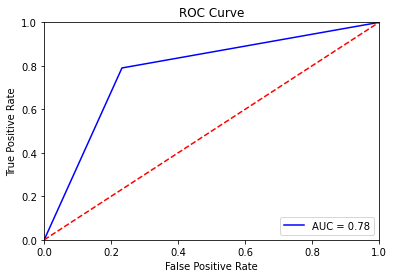

In [83]:
features_train, features_test, labels_train, labels_test = train_test_split(features_pyod, labels_pyod, 
                                                                            test_size=0.2, random_state=42)

clf = LogisticRegression(C = 10, class_weight = 'balanced', max_iter = 300)

t0 = time()
clf.fit(features_train, labels_train)
print("training time:", round(time()-t0, 3), "s")

t0 = time()
pred = clf.predict(features_test)
print("prediction time:", round(time()-t0, 3), "s")

print(classification_report(labels_test, pred, target_names=['not_attend', 'attend']), '-'*40, '\n',
      confusion_matrix(labels_test, pred), '\n', '-'*40)

fpr, tpr, threshold = roc_curve(labels_test, pred)

roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

<li><a href="#treeroc">DT ROC_AUC</a></li>

<a id='treecross'></a>

In [90]:
clf = tree.DecisionTreeClassifier(class_weight='balanced')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(clf, features_best_df_sfm, labels, scoring=metric, cv=cv, n_jobs=-1)
predictions = cross_val_predict(clf, features_best_df_sfm, labels, cv = 10, n_jobs = -1)

print(classification_report(labels, predictions, target_names=['not_attend', 'attend']), '-'*40, '\n',
      confusion_matrix(labels, predictions), '\n', '-'*40, '\n',
      'Mean ROC_AUC: %f (Std: %f)' % (scores.mean(), scores.std()))

              precision    recall  f1-score   support

  not_attend       0.20      0.88      0.32      6300
      attend       0.99      0.70      0.82     75740

    accuracy                           0.72     82040
   macro avg       0.59      0.79      0.57     82040
weighted avg       0.93      0.72      0.78     82040
 ---------------------------------------- 
 [[ 5554   746]
 [22479 53261]] 
 ---------------------------------------- 
 Mean ROC_AUC: 0.859311 (Std: 0.006018)


In [91]:
master_df_clean_ml.shape, features_best_df_sfm.shape

((82040, 10), (82040, 3))

In [92]:
# Current status of SMS reminders distribution

master_df_clean_ml.groupby(['sms_received', 'attend']).size()

sms_received  attend
0             0          3379
              1         55392
1             0          2921
              1         20348
dtype: int64

If we look at SMS reminder distribution that is currently prevailing before applying the model, we can note that a total of 23,269 SMS were sent to patients of which 13% (2,921) did not attend, while 87% (20,348) of reminders were sent to patient who actually attended.

If our model was deployed the focus would shift to patients who are predicted to not attend with a total of 28,033 ('No' predictions). Thus, SMS reminders would have targeted 20% (5,554) of patients who did not actually attend their appointments while maintaining even lower reminder rate of around 80% (22,479) for patients who did.

Moreover, this 20% (5,554) targeted by our model do represent 88% of all patients who actually did not attend their appointment (6,300) vs. only 46% before deploying the model.

<li><a href="#logcross">LR cross_val</a></li>

<a id='treeroc'></a>

training time: 0.321 s
prediction time: 0.019 s
              precision    recall  f1-score   support

  not_attend       0.20      0.87      0.33      1258
      attend       0.99      0.71      0.83     15150

    accuracy                           0.73     16408
   macro avg       0.59      0.79      0.58     16408
weighted avg       0.93      0.73      0.79     16408
 ---------------------------------------- 
 [[ 1097   161]
 [ 4351 10799]] 
 ----------------------------------------


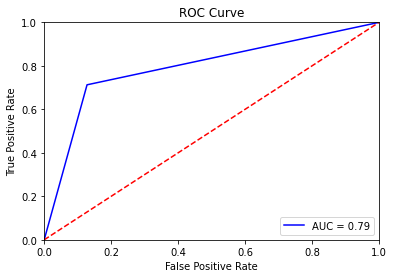

In [93]:
features_train, features_test, labels_train, labels_test = train_test_split(features_best_df_sfm, labels, 
                                                                            test_size=0.2, random_state=42)

clf = tree.DecisionTreeClassifier(class_weight='balanced', criterion='entropy', max_depth=100, random_state=42)

t0 = time()
clf.fit(features_train, labels_train)
print("training time:", round(time()-t0, 3), "s")

t0 = time()
pred = clf.predict(features_test)
print("prediction time:", round(time()-t0, 3), "s")

print(classification_report(labels_test, pred, target_names=['not_attend', 'attend']), '-'*40, '\n',
      confusion_matrix(labels_test, pred), '\n', '-'*40)

fpr, tpr, threshold = roc_curve(labels_test, pred)

roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

<li><a href="#logroc">LR ROC_AUC</a></li>

training time: 0.476 s
prediction time: 0.016 s
              precision    recall  f1-score   support

  not_attend       0.20      0.87      0.33      1258
      attend       0.98      0.71      0.83     15150

    accuracy                           0.73     16408
   macro avg       0.59      0.79      0.58     16408
weighted avg       0.92      0.73      0.79     16408
 ---------------------------------------- 
 [[ 1092   166]
 [ 4343 10807]] 
 ----------------------------------------


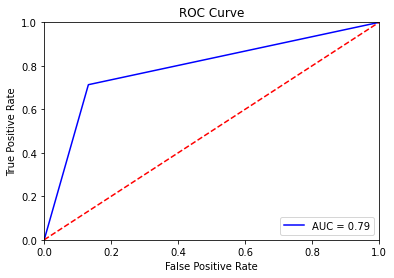

In [94]:
clf = tree.DecisionTreeClassifier()

over = SMOTE(random_state=42)

feat_resampled, lab_resampled = over.fit_resample(features_train, labels_train)

t0 = time()
clf.fit(feat_resampled, lab_resampled)
print("training time:", round(time()-t0, 3), "s")

t0 = time()
pred = clf.predict(features_test)
print("prediction time:", round(time()-t0, 3), "s")

print(classification_report(labels_test, pred, target_names=['not_attend', 'attend']), '-'*40, '\n',
      confusion_matrix(labels_test, pred), '\n', '-'*40)

fpr, tpr, threshold = roc_curve(labels_test, pred)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

training time: 0.042 s
prediction time: 0.021 s
              precision    recall  f1-score   support

  not_attend       0.20      0.89      0.32      1258
      attend       0.99      0.70      0.82     15150

    accuracy                           0.72     16408
   macro avg       0.59      0.79      0.57     16408
weighted avg       0.93      0.72      0.78     16408
 ---------------------------------------- 
 [[ 1114   144]
 [ 4513 10637]] 
 ----------------------------------------


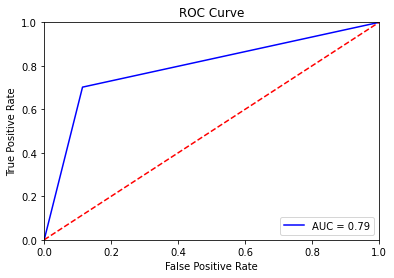

In [95]:
under = RandomUnderSampler(random_state=42)

feat_resampled, lab_resampled = under.fit_resample(features_train, labels_train)

t0 = time()
clf.fit(feat_resampled, lab_resampled)
print("training time:", round(time()-t0, 3), "s")

t0 = time()
pred = clf.predict(features_test)
print("prediction time:", round(time()-t0, 3), "s")

print(classification_report(labels_test, pred, target_names=['not_attend', 'attend']), '-'*40, '\n',
      confusion_matrix(labels_test, pred), '\n', '-'*40)

fpr, tpr, threshold = roc_curve(labels_test, pred)
roc_auc = auc(fpr, tpr)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate');

Different sampling techniques did not provide material difference in model performance.

<a id='predconc'></a>

### Predictions conclusion -  Who's To Blame?

Well, since I have a lot of unanswered questions highlighted in the conclusion section of the EDA and the fact that available features are not informative; I can't really decide who is to blame.

As noted earlier while analysing the records of patients having multiple appointments, where several discrepancies were noted in appointment setting and follow-up via SMS reminders, there is clearly a room for improvement in appointment administration procedures.

Decision Tree classifier has the best performance minimizing false positives while maintaining high recall and AUC_ROC score over minority class (patients who do not attend). 

While this model might not be pretty given high false negative rate, it does a decent job channeling efforts towards patients who are most likely to miss their medical appointments.

<li><a href="#treecross">DT cross_val</a></li>

<li><a href="#toc">Table of content</a></li>